<a href="https://colab.research.google.com/github/harshitha2403/Hate-Speech-Detection/blob/main/Final_DGH_distilbert_base_cased.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import numpy as np
from sklearn.metrics import precision_score, f1_score, confusion_matrix,classification_report, ConfusionMatrixDisplay
from datasets import load_metric
import torch
from transformers import TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#loading the dataset
train = pd.read_csv("drive/My Drive/DGH/trainDGH.csv")
test = pd.read_csv("drive/My Drive/DGH/testDGH.csv")

In [ ]:
print(train.shape)
test.head()

(30858, 3)


,acl.id,text,label
0,acl4929,black people should not have rights,1
1,acl30389,Seriously? Atheists do not CARE about religion...,0
2,acl16337,"filthy food, filthy houses. This is why we hav...",1
3,acl8017,A survey undertaken in Birmingham in 1956 foun...,0
4,acl28241,One day these nazi punchers could reveal that ...,0


In [ ]:
print(test.shape)
test.head()

(10286, 3)


,acl.id,text,label
0,acl4929,black people should not have rights,1
1,acl30389,Seriously? Atheists do not CARE about religion...,0
2,acl16337,"filthy food, filthy houses. This is why we hav...",1
3,acl8017,A survey undertaken in Birmingham in 1956 foun...,0
4,acl28241,One day these nazi punchers could reveal that ...,0


In [ ]:
# Loading train and test dataset using the 'datasets' library
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
#Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/30858 [00:00<?, ? examples/s]

Map:   0%|          | 0/10286 [00:00<?, ? examples/s]

In [ ]:
#Loading the model
checkpoint = "distilbert-base-cased"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#loading the ecaluation metrics
metric_acc = load_metric("accuracy")
metric_prec = load_metric("precision")
metric_recall = load_metric("recall")
metric_f1 = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = metric_acc.compute(predictions=predictions, references=labels)["accuracy"]
    prec = metric_prec.compute(predictions=predictions, references=labels)["precision"]
    rec = metric_recall.compute(predictions=predictions, references=labels)["recall"]
    f1 = metric_f1.compute(predictions=predictions, references=labels)["f1"]
    cm = confusion_matrix(labels, predictions)

    return {"accuracy": acc,"precision": prec, "recall": rec, "f1":f1, "confusion_matrix": cm.tolist()}

<ipython-input-13-a07985d5bddc>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric_acc = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for precision contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/precision.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for recall contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/recall.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=4)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.512000,0.468530,0.770756,0.773336,0.812951,0.792649,"[[3421, 1321], [1037, 4507]]"
2,0.406400,0.558721,0.772604,0.766683,0.830988,0.797542,"[[3340, 1402], [937, 4607]]"
3,0.296400,0.725121,0.764145,0.783764,0.776696,0.780214,"[[3554, 1188], [1238, 4306]]"
4,0.237900,1.052174,0.758021,0.775772,0.775072,0.775422,"[[3500, 1242], [1247, 4297]]"


Trainer is attempting to log a value of "[[3421, 1321], [1037, 4507]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3340, 1402], [937, 4607]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3554, 1188], [1238, 4306]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[[3500, 1242], [1247, 4297]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


TrainOutput(global_step=15432, training_loss=0.3630497686723281, metrics={'train_runtime': 6442.8076, 'train_samples_per_second': 19.158, 'train_steps_per_second': 2.395, 'total_flos': 1.6350715950907392e+16, 'train_loss': 0.3630497686723281, 'epoch': 4.0})

Trainer is attempting to log a value of "[[3500, 1242], [1247, 4297]]" of type <class 'list'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.



Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.74      0.74      4742
           1       0.78      0.78      0.78      5544

    accuracy                           0.76     10286
   macro avg       0.76      0.76      0.76     10286
weighted avg       0.76      0.76      0.76     10286



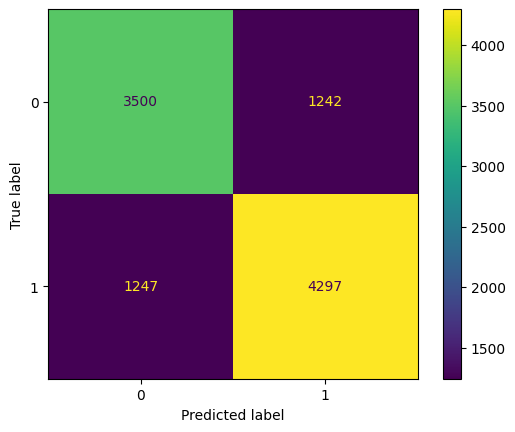

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"]).predictions.argmax(axis=-1)
true_labels = tokenized_datasets["test"]["label"]

eval_results = trainer.evaluate()
cm = np.array(eval_results['eval_confusion_matrix'])
print('\nClassification report: \n', classification_report(true_labels, predictions))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [ ]:
model.save_pretrained("CustomModels/CustomHamSpam")
tokenizer.save_pretrained("CustomModels/CustomHamSpam")

('CustomModels/CustomHamSpam/tokenizer_config.json',
 'CustomModels/CustomHamSpam/special_tokens_map.json',
 'CustomModels/CustomHamSpam/vocab.txt',
 'CustomModels/CustomHamSpam/added_tokens.json',
 'CustomModels/CustomHamSpam/tokenizer.json')

In [ ]:
from transformers import pipeline

data = ["You walk like a human"]
classifier = pipeline("sentiment-analysis")  # Specify a task like sentiment analysis
result = classifier(data[0])  # Pass the text string, not the list
print(result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'POSITIVE', 'score': 0.9994863271713257}]
